In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, LSTM, GRU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Time Series Analysis of Google Stock Price Data

Time series data is a sequence of data points indexed by time, and it's essential for analyzing trends. In this project, we will analyze stock market data from Google. Using **yfinance**, we will gather stock data and visualize key metrics with **Seaborn** and **Matplotlib**.

Our main focus will be on:
1. Analyzing stock price changes over time.
2. Calculating the average daily return.
3. Investigating moving averages.
4. Understanding the risks of investing in Google's stock.
5. Predicting future stock prices using **LSTM**.

By the end of this project, we will have gained insights into stock behavior and built a prediction model for Google's stock price.


In [4]:
google = pd.read_csv('GOOGL_2004-08-01_2024-12-18.csv', index_col = 'Date', parse_dates = True )
google.columns = google.columns.str.replace(' ', '_')
google.head()

Open      High       Low     Close  Adj_Close     Volume
Date                                                                    
2004-08-19  2.502503  2.604104  2.401401  2.511011   2.501941  893181924
2004-08-20  2.527778  2.729730  2.515015  2.710460   2.700670  456686856
2004-08-23  2.771522  2.839840  2.728979  2.737738   2.727849  365122512
2004-08-24  2.783784  2.792793  2.591842  2.624374   2.614895  304946748
2004-08-25  2.626627  2.702703  2.599600  2.652653   2.643072  183772044

In [5]:
google.describe()

Open         High          Low        Close    Adj_Close  \
count  5118.000000  5118.000000  5118.000000  5118.000000  5118.000000   
mean     47.639701    48.139771    47.149358    47.654613    47.490963   
std      45.736050    46.241037    45.269941    45.763431    45.621100   
min       2.482232     2.546046     2.401401     2.502753     2.493713   
25%      13.176239    13.307683    13.039790    13.182808    13.135192   
50%      28.003501    28.195346    27.751500    27.969750    27.868724   
75%      62.746125    63.414874    62.220124    62.900626    62.673431   
max     197.250000   201.419998   194.979996   196.660004   196.660004   

             Volume  
count  5.118000e+03  
mean   1.157640e+08  
std    1.470189e+08  
min    9.312000e+06  
25%    3.064900e+07  
50%    5.752321e+07  
75%    1.393135e+08  
max    1.643023e+09

In [6]:
print(google.index.min())
print(google.index.max())

google.index = pd.to_datetime(google.index)
google['DayOfWeek'] = google.index.day_name()
google['DayOfWeek'].value_counts(normalize = True)

2004-08-19 00:00:00
2024-12-17 00:00:00


DayOfWeek
Wednesday    0.205354
Tuesday      0.205158
Thursday     0.201837
Friday       0.200664
Monday       0.186987
Name: proportion, dtype: float64

Our dataset contains the stock price data for **Google** from **August 19, 2004** to **December 17, 2024**. 

There is no trading data available over the weekends, which is typical for traditional stock markets. 
Upon examining the data, we observe a small difference in returns across weekdays, with **Wednesday** showing the highest return. However, the variation in returns between weekdays is minimal.
Given the small differences between weekdays and the absence of weekend data, the day of the week does not provide significant predictive value for the model. 
Thus, weekdays are unlikely to be useful features for improving model performance.


In [7]:
google.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5118 entries, 2004-08-19 to 2024-12-17
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5118 non-null   float64
 1   High       5118 non-null   float64
 2   Low        5118 non-null   float64
 3   Close      5118 non-null   float64
 4   Adj_Close  5118 non-null   float64
 5   Volume     5118 non-null   int64  
 6   DayOfWeek  5118 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 319.9+ KB


# Close vs Adjusted Close

The **Close** price is crucial in stock analysis as it reflects the final trading price of the day, indicating the market's consensus.
It is essential for identifying trends, support/resistance levels, and price movements, and is commonly used in technical indicators like moving averages.

- **For modeling**: **Close** is used as it represents the actual price at the end of the trading day and is the most straightforward for predictive models.
- **For visualization**: **Adj_Close** is preferred as it adjusts for corporate actions like dividends and stock splits, offering a more accurate trend representation.


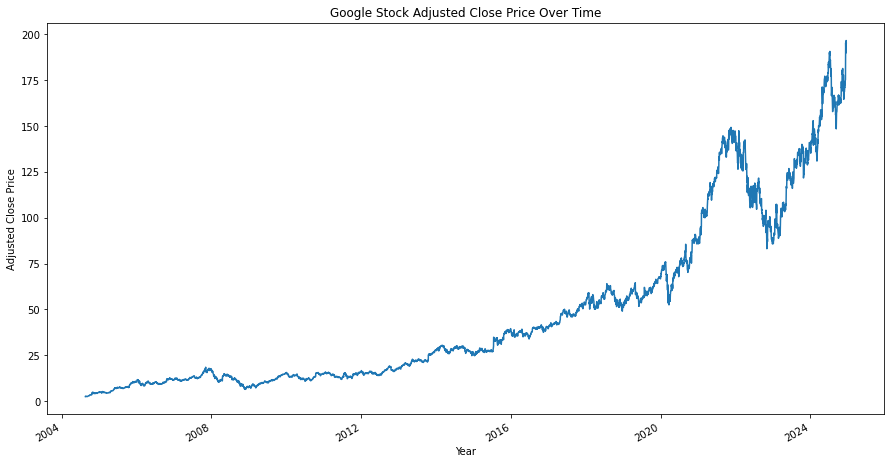

In [8]:
google['Adj_Close'].plot(figsize=(15,8))
plt.title('Google Stock Adjusted Close Price Over Time')
plt.xlabel('Year')
plt.ylabel('Adjusted Close Price')
plt.show()

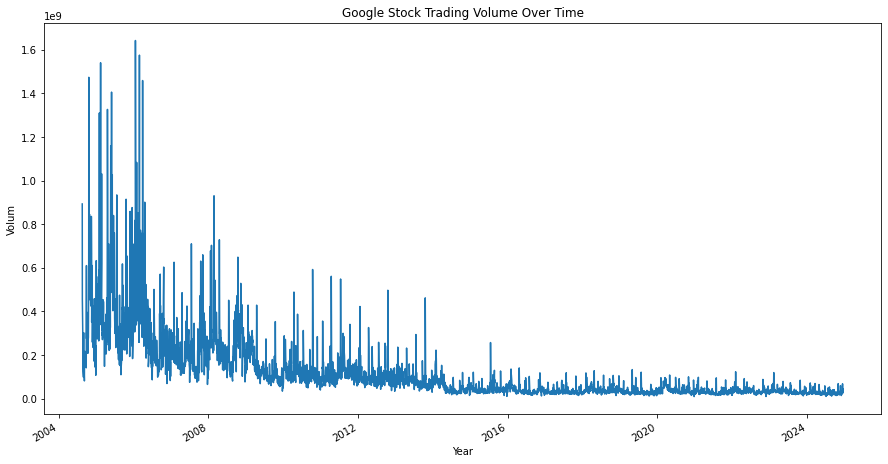

In [9]:
google['Volume'].plot(figsize=(15,8))
plt.title('Google Stock Trading Volume Over Time')
plt.xlabel('Year')
plt.ylabel('Volum')
plt.show()

# Google Stock Price and Trading Volume Analysis

The two charts we’re looking at—**Google's Stock Price** and **Trading Volume**—provide insights into how the stock has performed over time. Here's a simple breakdown of what they show:

1. **Price and Volume Relationship**:
   - Normally, when stock prices go up, we expect more people to buy and sell (increasing trading volume). In Google’s case, while the **stock price** has been rising steadily since 2015, the **trading volume** has been going down. This suggests that although the stock price is increasing, fewer people are trading Google’s stock, indicating that it may be becoming more stable and less speculative.

2. **Spikes in Trading Volume**:
   - In the early years (around **2004-2006**), there was a big surge in trading volume, likely because of Google’s initial public offering (IPO) and other major events. This is typical for a company that’s just starting to be traded publicly.
   - After this initial spike, the trading volume gradually decreased, which is common for more mature companies like Google. When stocks become more well-established, trading tends to level off.

3. **Stability and Growth**:
   - Over the past few years, the **trading volume** has become much smaller, which often happens when a stock becomes less volatile and more predictable. This could mean that **large institutional investors** are buying and holding shares, rather than a lot of smaller, short-term traders.

4. **Implications for Stock Predictions**:
   - If we want to predict future stock prices, understanding both the **price** and **volume** is important. For example, higher trading volume during times of big price changes can give us clues about the strength of the price movement. However, with Google's stock showing less volume in recent years, it might not be as helpful for predictions anymore.
   - We could consider combining price and volume data to better understand market trends and potential risks.

### Conclusion:
These two charts together show that while Google’s stock price has been rising, the trading activity has been decreasing. This suggests that Google’s stock is becoming more stable over time, with fewer people actively trading it. This kind of analysis can help us understand the stock’s long-term growth and predict future price movements with more confidence.


<AxesSubplot:title={'center':'Google Stock Price and Simple Moving Averages'}, xlabel='Date'>

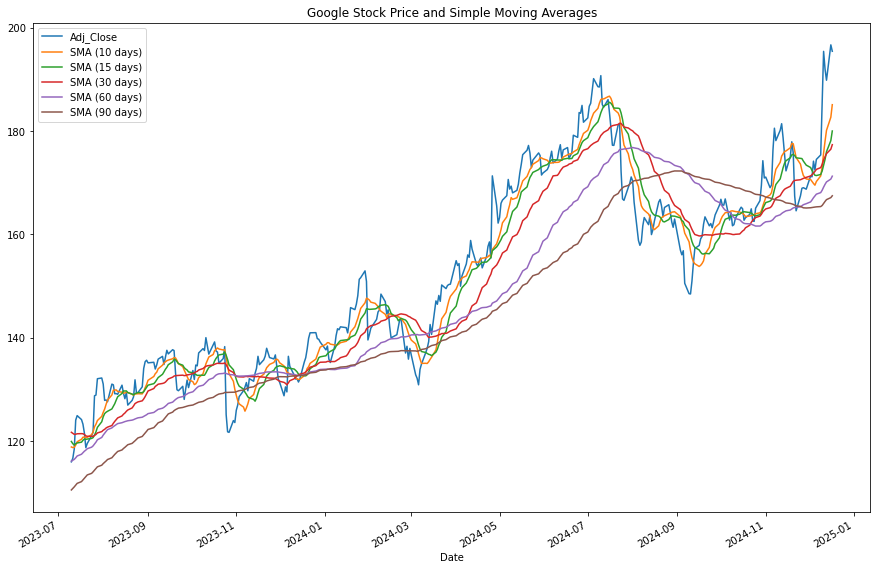

In [10]:
window_sizes = [10,15,30,60,90]

# Loop through the defined window sizes and calculate the moving average
for window in window_sizes:
    col_name = f"SMA ({window} days)"
    google[col_name] = google['Adj_Close'].rolling(window).mean()

# Plot the adjusted close prices along with the calculated moving averages
google[['Adj_Close', 'SMA (10 days)', 'SMA (15 days)', 'SMA (30 days)','SMA (60 days)', 'SMA (90 days)']].tail(365).plot(figsize=(15, 10), title="Google Stock Price and Simple Moving Averages")

# **Google Stock Price and Simple Moving Averages (SMA)**
## **Overview**
This visualization presents Google's **Adjusted Close Price** alongside multiple **Simple Moving Averages (SMA)** over different time periods (**10, 15, 30, 60, and 90 days**). The purpose of this analysis is to observe market trends, smooth out short-term fluctuations, and identify potential buy/sell signals.

---

## **Key Insights**
- **Short-Term vs. Long-Term Trends:**
  - **Short-term SMAs (10, 15, 30 days)** closely follow stock price movements, reacting quickly to price changes.
  - **Longer SMAs (60, 90 days)** smooth out volatility and help in identifying **overall trends**.

- **Moving Average Crossover Signals:**
  - When a **short-term SMA crosses above a long-term SMA**, it may indicate a **buy signal**.
  - Conversely, when a **short-term SMA crosses below a long-term SMA**, it could be a **sell signal**.
  - These crossovers help traders anticipate momentum shifts.

- **Recent Stock Movement:**
  - The chart highlights a **strong upward trend** in recent months.
  - The **short-term SMAs are crossing above the longer SMAs**, which may indicate **bullish momentum**.

---

## **Implications for Modeling**
- **Feature Engineering:**  
  - SMA values can be used as input features in deep learning models to capture price momentum.  
  - SMA crossovers could be incorporated as **binary signals** for classification models (predicting uptrend or downtrend).  

- **Modeling Considerations:**  
  - Short-term SMAs are more **reactive** but prone to false signals.  
  - Long-term SMAs are more **reliable** but may lag behind price movements.  
  - A **hybrid approach** combining SMAs with other technical indicators (e.g., RSI, MACD) could improve prediction accuracy.

---

## **Conclusion**
Simple Moving Averages provide valuable insights into **stock price trends and momentum shifts**. The recent SMA behavior suggests an **uptrend**, but further analysis is needed to confirm whether this trend is **sustainable or a short-term fluctuation**. These insights will be leveraged in the deep learning model for predictive analysis.


<AxesSubplot:xlabel='Date'>

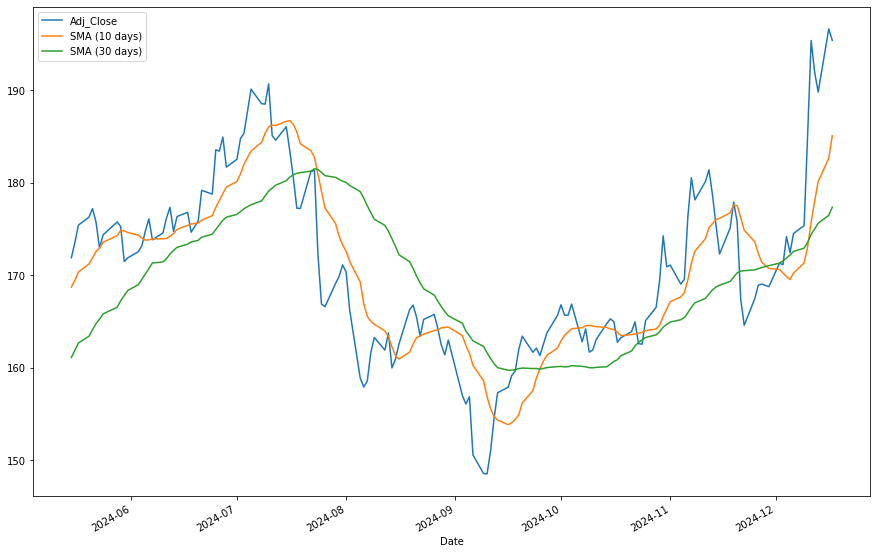

In [78]:
google[['Adj_Close','SMA (10 days)', 'SMA (30 days)']].tail(150).plot(figsize=(15, 10))

This plot compares Google's Adjusted Close Price with Simple Moving Averages (SMA) for 10 days, 18 days, and 30 days over the past 150 trading days.

**Key Observations:**

The 10-day SMA (orange) closely follows short-term price fluctuations, reacting quickly to market movements.
The 30-day SMA (green) smooths out volatility, providing a longer-term trend perspective.
A bullish crossover occurs when the short-term SMA crosses above the long-term SMA, potentially signaling an upward trend.
Recent data shows an uptrend, with the stock price moving above both SMAs, indicating potential bullish momentum.
This analysis suggests that short-term price movements are gaining momentum, which may indicate continued growth if the trend sustains.

In [12]:
google['log_adj_close'] = np.log(google['Adj_Close'])

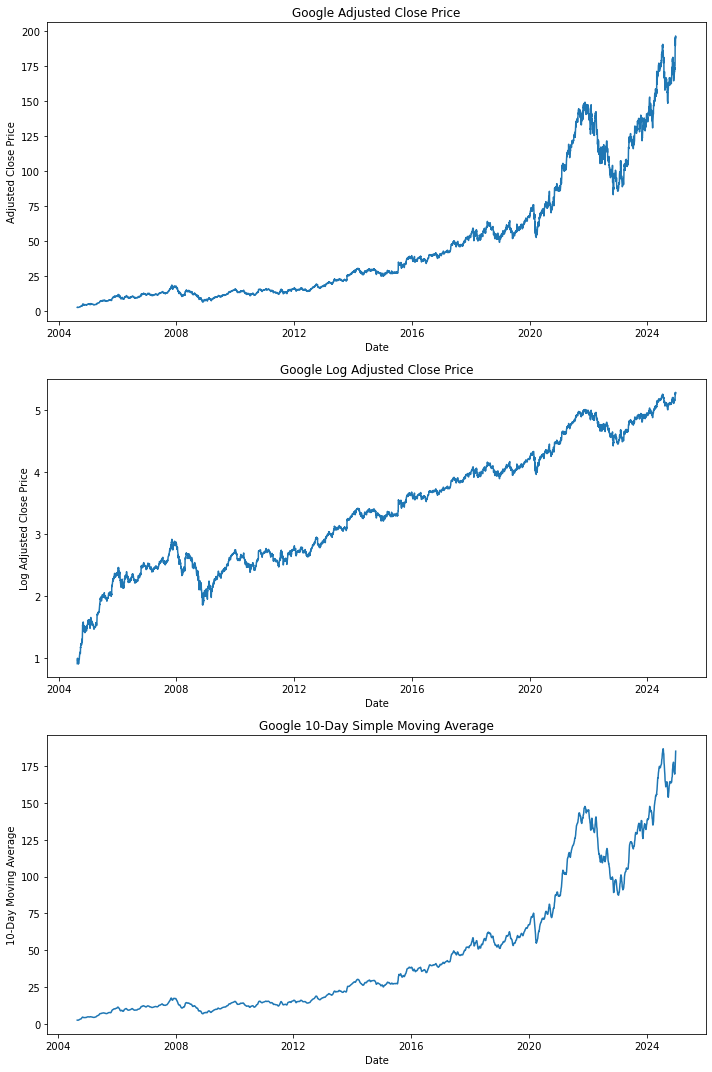

In [13]:
# Create a figure and a 3-row, 1-column grid for subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot 'Adj_Close' in the second subplot
axes[0].plot(google['Adj_Close'])
axes[0].set_title('Google Adjusted Close Price')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Adjusted Close Price')

# Plot 'log_adj_close' in the first subplot
axes[1].plot(google['log_adj_close'])
axes[1].set_title('Google Log Adjusted Close Price')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log Adjusted Close Price')


# Plot 'MA (10 days)' in the third subplot
axes[2].plot(google['SMA (10 days)'])
axes[2].set_title('Google 10-Day Simple Moving Average')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('10-Day Moving Average')

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

<AxesSubplot:xlabel='Date'>

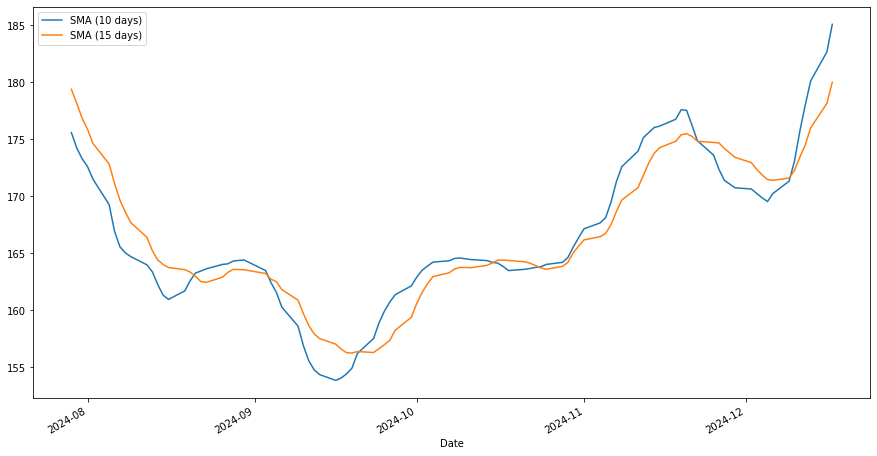

In [14]:
google[['SMA (10 days)','SMA (15 days)']].tail(100).plot(figsize=(15,8))

### Summary of Moving Average (10 days) Choice

Based on the comparison of the plots, we observe that the **10-day Moving Average (MA)** captures the best short-term trends over the years.

- **Smoothing Effect**: The MA(10) smooths out daily price fluctuations, allowing us to focus on the overall direction of the stock price, making it easier to identify trends.
- **Reduces Noise**: This moving average helps eliminate the noise or sudden price spikes that can interfere with accurate predictions.
- **Short-Term Forecasting**: Since we're interested in **short-term forecasting**, the 10-day moving average is ideal as it reflects the most recent market behavior without being too sensitive to daily fluctuations.
- **LSTM Suitability**: This shorter window aligns well with the LSTM model, as it helps the model learn recent trends and patterns in stock prices, improving the accuracy of predictions for short-term changes.

In conclusion, **MA(10 days)** provides a balanced view of recent price movements and trends, making it the best choice for our short-term forecasting model.


To conduct a deeper analysis of Google stock returns, we can break the analysis into several parts.

In [15]:
google['Return'] = google['Adj_Close'].pct_change()
#google['Daily_Return'].plot(figsize=(15,8), title="Google Daily Returns")

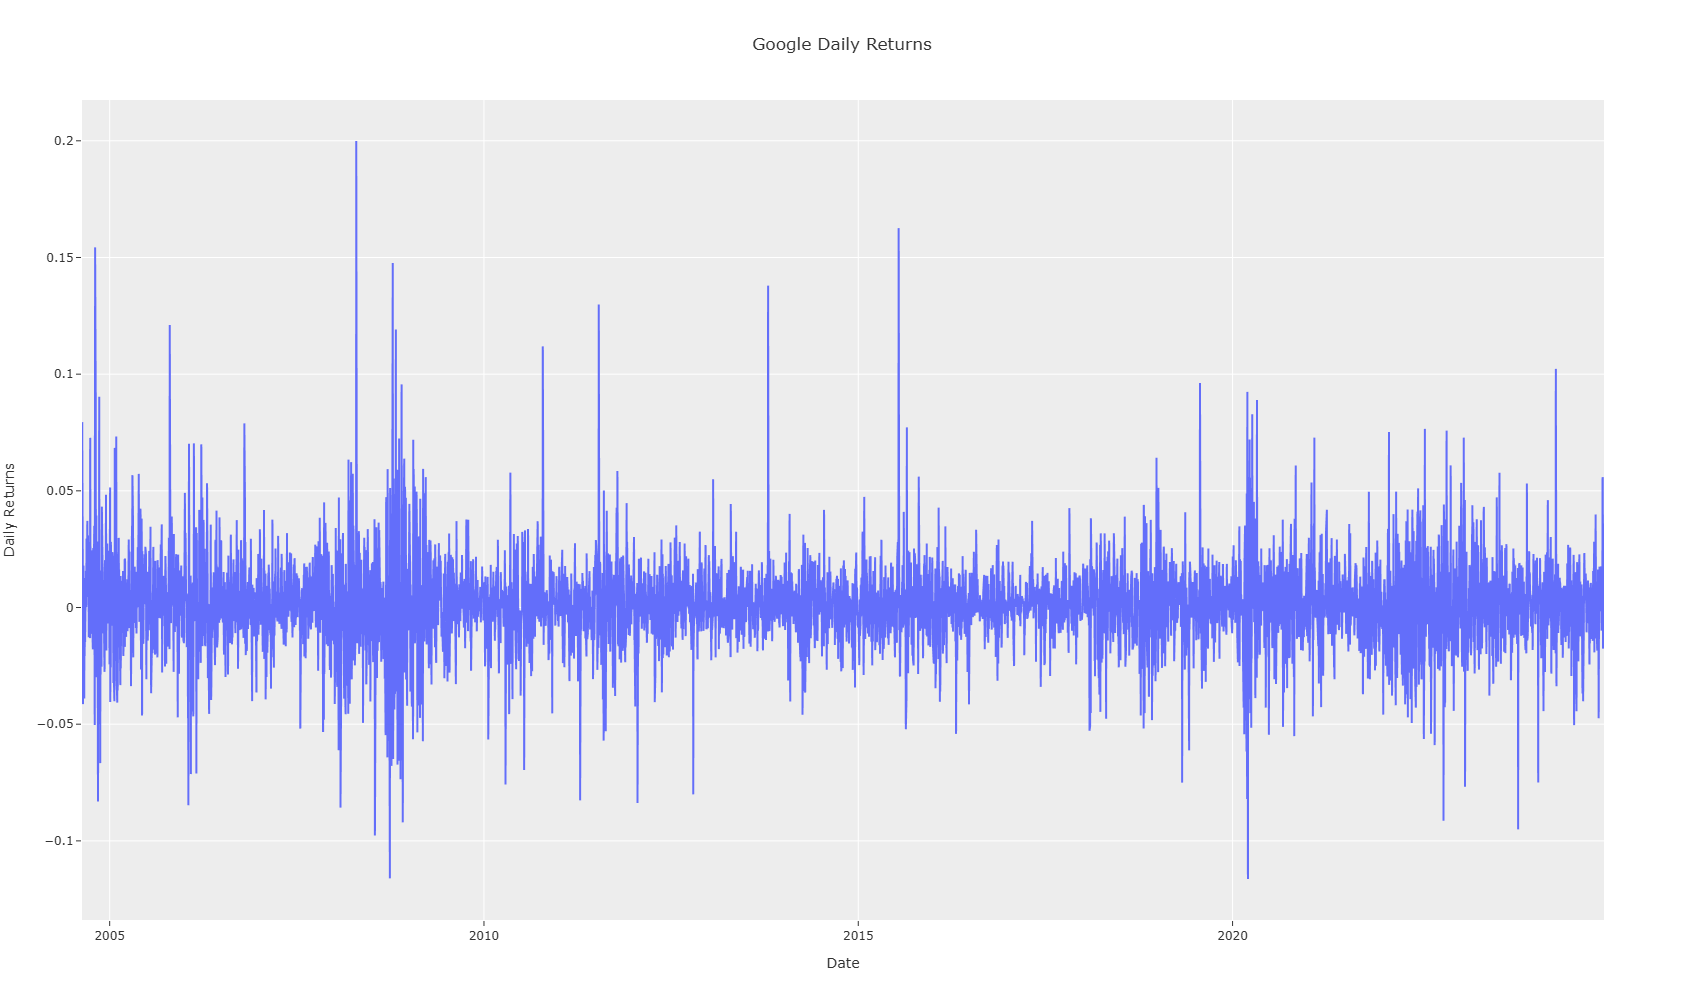

In [16]:
# Create the plot
fig = px.line(google, x=google.index, y='Return', title="Google Daily Returns")

# Customize the layout for better readability
fig.update_layout(
    height=1000,  # Height in pixels
    width=1500,   # Width in pixels
    xaxis_title="Date",
    yaxis_title="Daily Returns",
    template="ggplot2"  # You can adjust the theme to your preference
)

# Show the plot
fig.show()

## Google Daily Returns Analysis

The plot shows **Google Daily Returns** from 2004 to 2024, indicating key observations:

1. **Volatility**: The plot highlights periods of significant volatility, marked by large positive and negative spikes in daily returns. These spikes may correlate with market stress or major news events.
2. **Stable and High-Volatility Periods**: There are periods of consistent returns and others with more erratic movements, reflecting the market's changing sentiment.
3. **Clusters of Returns**: Periods of high or low returns seem to be clustered, suggesting external market factors influencing Google's stock price at various points in time.

### Next Steps for Deeper Analysis:

Given the observed volatility in the daily returns, the following analyses could be useful:
1. **Volatility Analysis**: Calculate rolling volatility (standard deviation) over different time windows to quantify stock risk. Consider using models like **GARCH** for conditional volatility.
2. **Autocorrelation**: Assess autocorrelation in returns to identify potential patterns, which can aid in time series forecasting using ARIMA or LSTM.
3. **Event Study**: Investigate specific spikes or dips in returns and correlate them with market events (e.g., earnings reports, industry news).
4. **Distribution of Returns**: Plot a histogram of returns to check for normality. Deviations from normality (e.g., fat tails) could indicate higher risk.
5. **Cumulative Returns**: Analyze cumulative returns over time to assess long-term trends and overall stock performance.

These steps will provide a deeper understanding of the stock's behavior and help inform predictive modeling approaches.


In [17]:
goog_plot = google.copy()

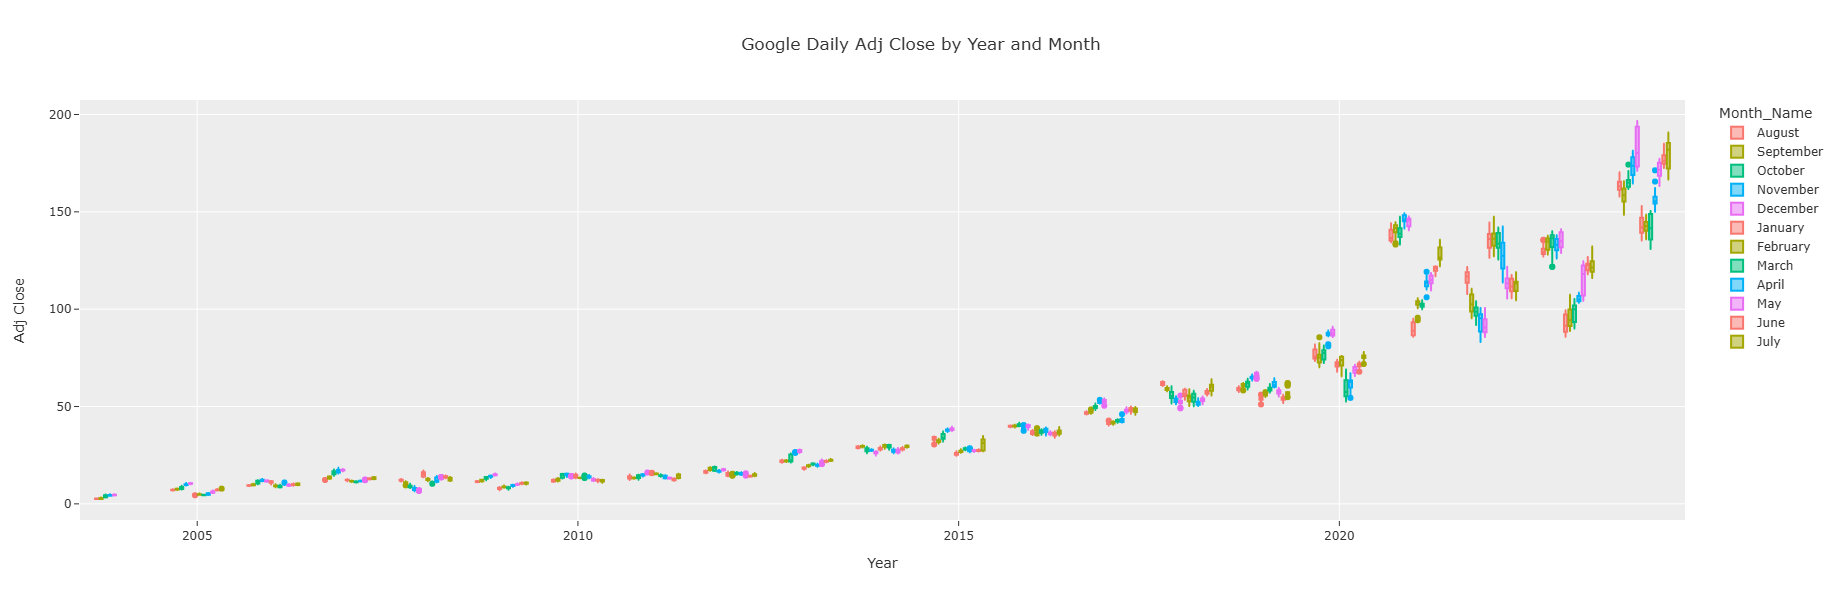

In [79]:
# Adding a column for the month for color coding
goog_plot['Month'] = goog_plot.index.month
goog_plot['Year'] = goog_plot.index.year.astype(int)

# Create a dictionary to map month numbers to names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Map month numbers to names
goog_plot['Month_Name'] = goog_plot['Month'].map(month_names)

# Create the box plot
fig = px.box(goog_plot, 
              x='Year', 
              y='Adj_Close',  # Replace with the column you're analyzing
              color='Month_Name',
              template="ggplot2",
              title="Google Daily Adj Close by Year and Month")

# Customize the layout
fig.update_layout(width=1100, height=600)
fig.update_xaxes(showgrid=True)  # Hide the X-axis gridlines
fig.update_yaxes(title_text='Adj Close', showgrid=True)  # Show Y-axis gridlines

# Show the figure
fig.show()


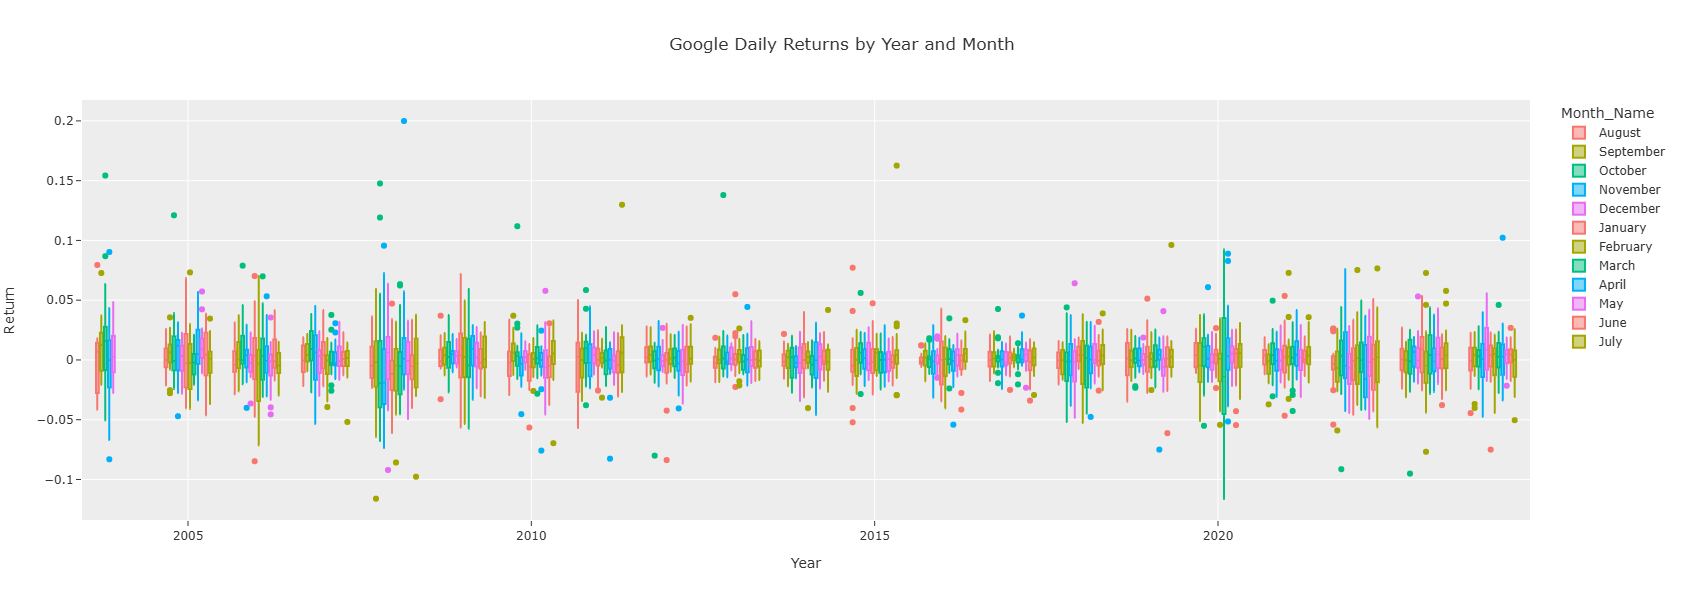

In [74]:
# Create the box plot
fig = px.box(goog_plot, 
              x='Year', 
              y='Return',  # Replace with the column you're analyzing
              color='Month_Name',
              template="ggplot2",
              title="Google Daily Returns by Year and Month")

# Customize the layout
fig.update_layout(width=1100, height=600)
fig.update_xaxes(showgrid=True)  # Hide the X-axis gridlines
fig.update_yaxes(showgrid=True)  # Show Y-axis gridlines

# Show the figure
fig.show()

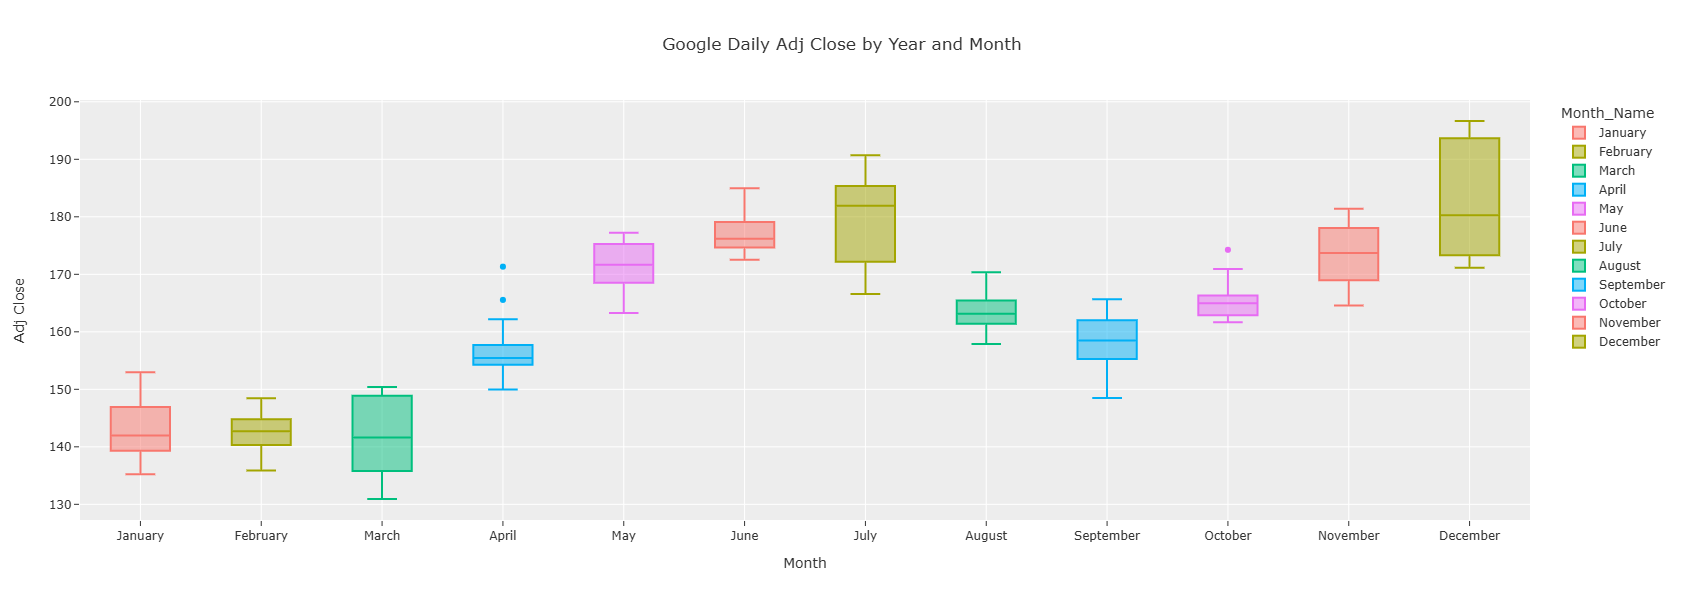

In [76]:
goog_plot[goog_plot.index.year == '2024']
# Create the box plot
fig = px.box(goog_plot[goog_plot.index.year == 2024], 
              x='Month_Name', 
              y='Adj_Close',  # Replace with the column you're analyzing
              color='Month_Name',
              template="ggplot2",
              title="Google Daily Adj Close by Year and Month")

# Customize the layout
fig.update_layout(width=1100, height=600)
fig.update_xaxes(title_text='Month', showgrid=True) # Hide the X-axis gridlines
fig.update_yaxes(title_text='Adj Close', showgrid=True)  # Show Y-axis gridlines

# Show the figure
fig.show()



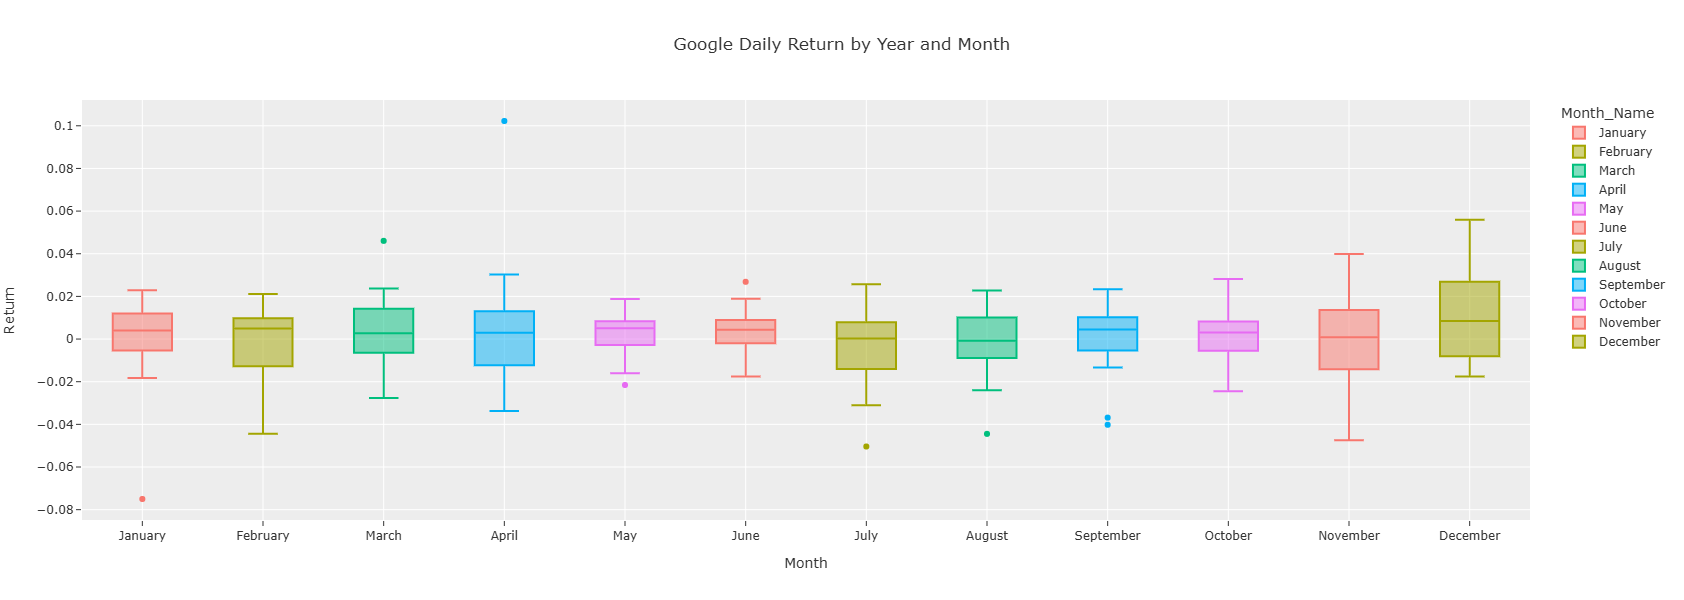

In [75]:
goog_plot[goog_plot.index.year == '2024']
# Create the box plot
fig = px.box(goog_plot[goog_plot.index.year == 2024], 
              x='Month_Name', 
              y='Return',  # Replace with the column you're analyzing
              color='Month_Name',
              template="ggplot2",
              title="Google Daily Return by Year and Month")

# Customize the layout
fig.update_layout(width=1100, height=600)
fig.update_xaxes(title_text='Month', showgrid=True) # Hide the X-axis gridlines
fig.update_yaxes(title_text='Return', showgrid=True)  # Show Y-axis gridlines

# Show the figure
fig.show()


### Analysis of Google Daily Returns by Year and Month

- **Monthly Trends**:
  - **August (Month 8)** and **September (Month 9)** show higher peaks in daily returns, indicating greater volatility.
  - **January (Month 1)** has relatively stable returns, with fewer extreme values.

- **Annual Variation**:
  - Over the years, the range of daily returns has increased, suggesting growing stock price volatility, potentially due to market factors and company performance.

- **Distribution of Returns**:
  - There is a wider spread in daily returns in the mid-year months (June to September), indicating higher market fluctuations.

- **Extremes and Outliers**:
  - Some outliers in early years show significant stock price changes, possibly linked to major market events or company-specific news.

### Conclusion:
The plot reveals significant monthly variations in daily returns, with some months showing higher volatility. This could be important for short-term forecasting and understanding seasonal stock behavior.


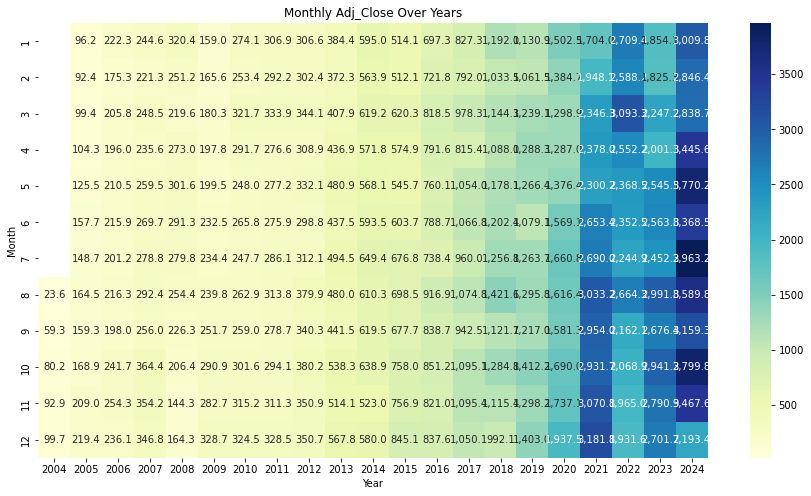

In [21]:
# Group data by year and month
monthly_return = google.groupby([google.index.year, google.index.month]).sum()

# Pivot the data to get years as columns and months as rows
heatmap_data = monthly_return['Return'].unstack(level=0)

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=",.1f")
plt.title('Monthly Adj Close Over Years')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


# Monthly Return Over Years - Heatmap Analysis

The heatmap below visualizes the monthly returns of Google stock over the years, providing insightful patterns and trends:

1. **Yearly Variations**: Each month’s return is compared across multiple years, revealing how the returns fluctuate over time. For instance, October (Month 10) tends to show higher returns in certain years like 2009, while other months like March display more consistent behavior.

2. **Positive vs Negative Returns**: The color gradient (from dark blue/purple for negative returns to light green/yellow for positive returns) helps to quickly distinguish between months that performed well versus those that underperformed. This can help identify opportunities for investing during historically positive months.

3. **Trends and Patterns Over Time**: Some months, like September (Month 9), show a consistent pattern of positive returns across several years. In contrast, other months, such as July, show more variability in performance.

4. **Consistency in Certain Months**: Some months, like March and May, display more consistent return patterns across the years, making these months potentially more reliable for forecasting stock behavior.

### Conclusion:
This heatmap effectively highlights the seasonal behavior of Google stock, making it a useful tool for identifying months with consistent positive or negative returns. By leveraging this analysis, investors could make more informed decisions, potentially aligning their investment strategies with favorable months based on historical trends.


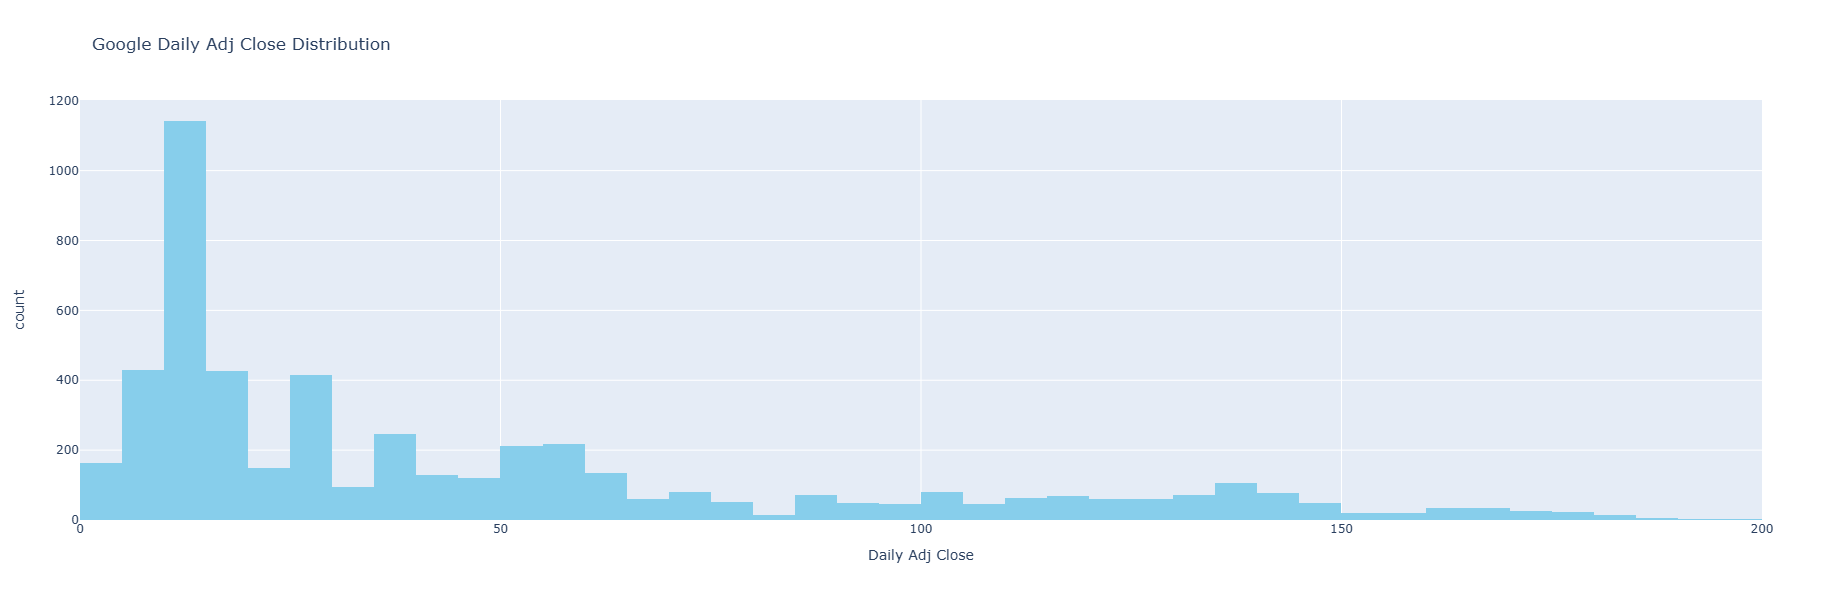

In [81]:
import plotly.express as px

# Assuming 'google' is your DataFrame and 'Return' is the column with daily returns

fig = px.histogram(google, x='Adj_Close', nbins=50, color_discrete_sequence=['skyblue'], 
                   title="Google Daily Adj Close Distribution", 
                   labels={"Adj_Close": "Daily Adj Close"})

fig.update_layout(width=1100, height=600)
fig.update_xaxes(showgrid=True)  # Hide the X-axis gridlines
fig.update_yaxes(showgrid=True)  # Show Y-axis gridlines

# Show the figure
fig.show()



## Analysis of Google Daily Returns Distribution

The histogram of **Google Daily Returns** showcases the distribution of the daily stock price changes for Google. The key points from this plot are:

1. **Peak Around Zero**: The histogram shows a peak around 0, meaning that most of the daily returns are close to zero. This indicates that on a daily basis, the stock price of Google tends to stay relatively stable, with small fluctuations.

2. **Bimodal Distribution**: The distribution is not perfectly normal, as we can see a concentration around zero and then several larger deviations in both directions. This suggests that while most returns are small, there are periods of high volatility that could lead to larger gains or losses on some days.

3. **Skewed to the Right**: The histogram has a slightly positive skew, suggesting that the stock has a tendency for small positive returns, although this isn't very pronounced.

### Implications for Risk Assessment:
- **Short-Term Stability**: The peak around zero suggests that in the short term, Google’s stock exhibits relatively low volatility. 
- **Potential Outliers**: The larger deviations from zero (both positive and negative) suggest that while small daily fluctuations are common, there are also occasions where the stock price can experience larger moves. These outliers, though infrequent, can have a significant impact on the overall risk profile.
- **Investment Insight**: While the stock's daily returns are relatively stable, investors should still be mindful of sudden larger price movements that could occur from time to time.

### Conclusion:
- Google’s stock price seems stable on a daily basis, with most returns being small.
- Although the short-term risk seems moderate, larger fluctuations can still happen occasionally. These should be considered when evaluating the stock for short-term trading or long-term investment.


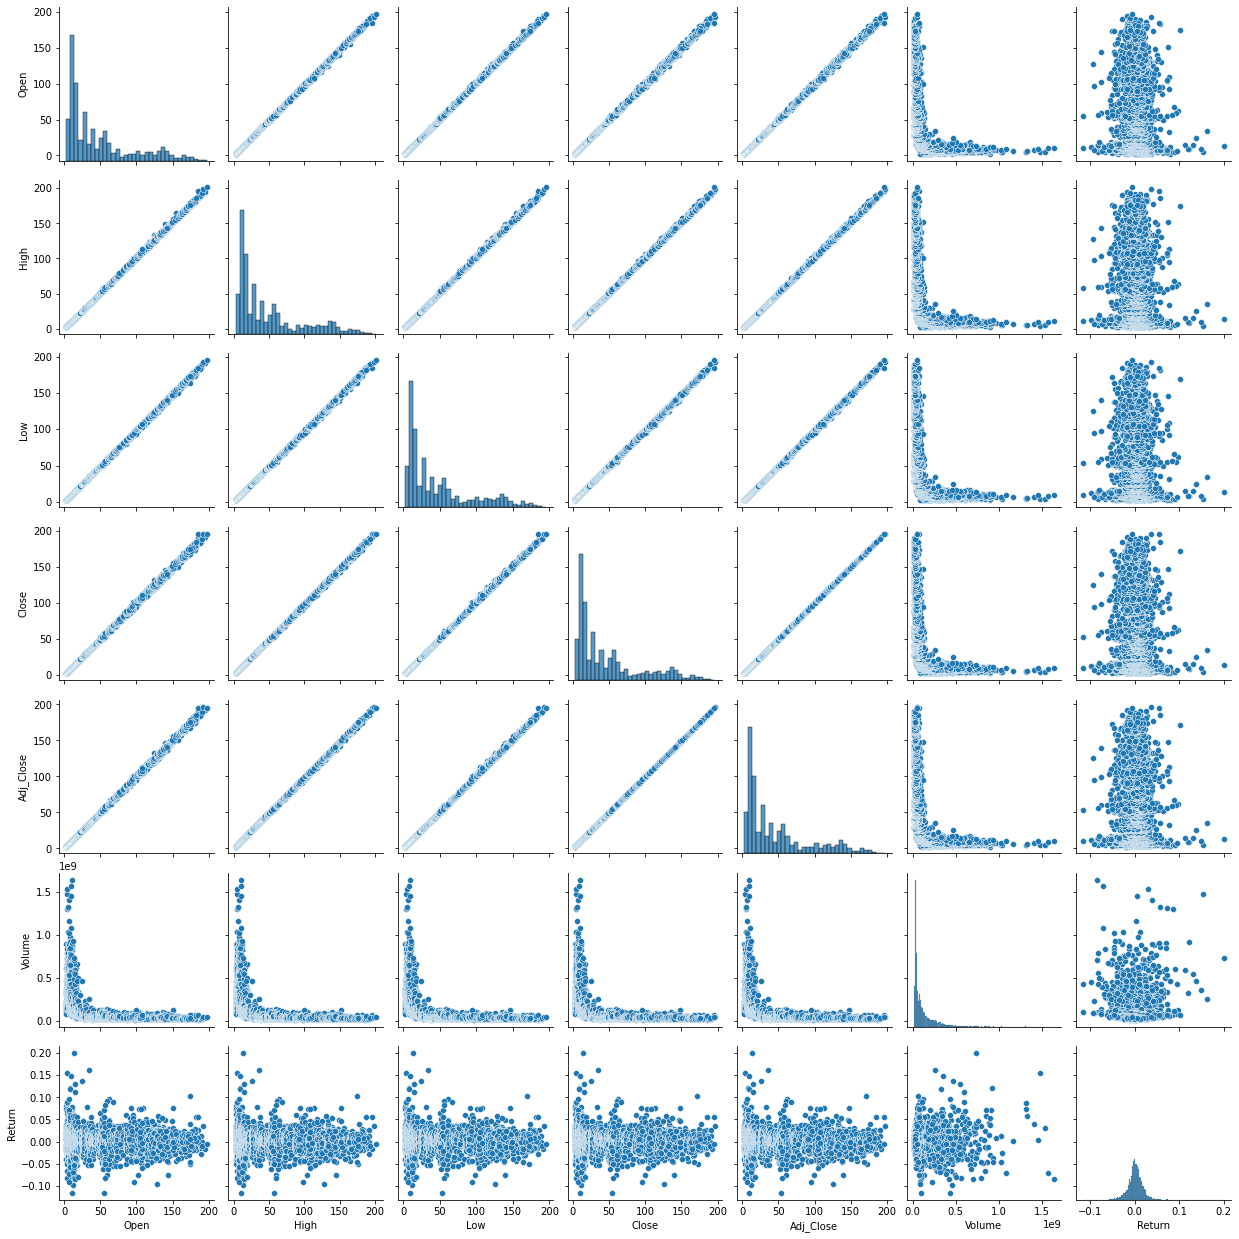

In [23]:
sns.pairplot(goog_plot[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Return']], diag_kind='hist')

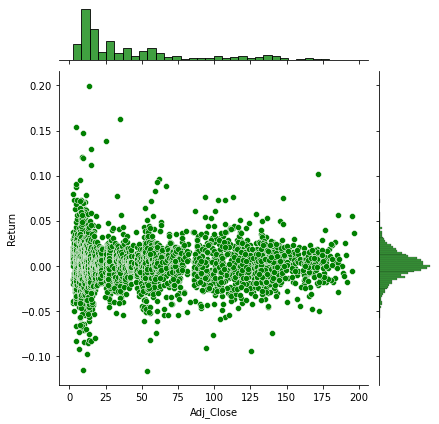

In [24]:
# jointplot between 'Adj_Close' and 'Daily_Return'
sns.jointplot(data=google, x='Adj_Close', y='Return', kind='scatter', color='green')



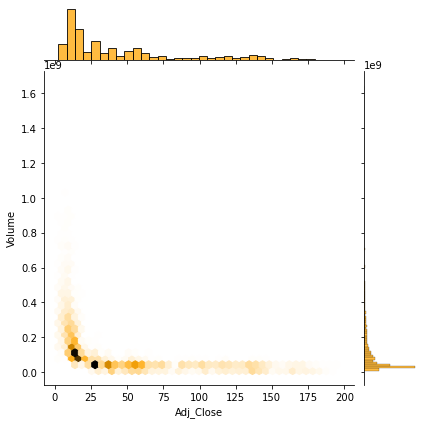

In [25]:
sns.jointplot(data=google, x='Adj_Close', y='Volume', kind='hex', color='orange')

This plot indicates that there is no strong, clear relationship between Google's daily returns and trading volume.

While large spikes in volume appear, they don't seem to correlate directly with significant positive or negative returns. 

Therefore, trading volume might not be an effective predictor of daily return changes for this stock in the short-term analysis.

# Modeling

In [26]:
df = google['Close'].copy().reset_index()

In [27]:
df.head()

Date     Close
0 2004-08-19  2.511011
1 2004-08-20  2.710460
2 2004-08-23  2.737738
3 2004-08-24  2.624374
4 2004-08-25  2.652653

In [28]:
df.shape

(5118, 2)

In [29]:
#Ntest = int(len(df) * 0.2)
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [30]:
train.shape

(5097, 2)

In [31]:
# Generate train and test indexes
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [32]:
scaler  = StandardScaler()
train_scaled = scaler.fit_transform(train[['Close']])
test_scaled = scaler.transform(test[['Close']])

In [33]:
# Check for missing values in a numpy array
missing_values = np.sum(np.isnan(train_scaled))
print(f"Number of missing values: {missing_values}")

Number of missing values: 0


In [34]:
def make_supervised_dataset(data, T=1):
    """
    Creates a supervised dataset from the scaled training data where 
    each sample consists of T previous time steps and the next time step price.
    
    Parameters:
    train_scaled (numpy array): The scaled training data.
    T (int): The number of previous time steps to use for prediction.
    
    Returns:
    X (numpy array): The features array (previous T time steps).
    Y (numpy array): The target array (next time step price).
    """
    X, Y = [], []  # Initialize lists to hold features and targets
    
    for t in range(len(data) - T):
        x = data[t : t + T]  # Sequence of T previous time steps
        X.append(x)
        y = data[t + T]     # The next time step price (target)
        Y.append(y)
    
    X = np.array(X).reshape(-1, T, 1)  # Reshape to RNN format (samples, time steps, features)
    Y = np.array(Y)
    
    print("X.shape:", X.shape, "Y.shape:", Y.shape)
    
    return X, Y
  


In [35]:
def evaluate_lstm_model(model, X_scaled, y_original, scaler, dataset_type="Test"):
    """
    Make predictions using an LSTM model, inverse transform the predictions,
    and calculate RMSE.
    
    Parameters:
    - model: Trained LSTM model
    - X_scaled: Scaled input data (Xtest_scaled or Xtrain_scaled)
    - y_original: Original target values (y_test_original or y_train_original)
    - scaler: Scaler object used for inverse transformation
    - dataset_type: "Test" or "Train" (for labeling outputs)
    
    Returns:
    - y_pred_original: Inverse-transformed predictions
    - rmse: RMSE score
    """
    # 1. Make predictions
    y_pred_scaled = model.predict(X_scaled)
    
    # 2. Inverse transform predictions to original scale
    y_pred_original = scaler.inverse_transform(y_pred_scaled)
    
    # 3. Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_original, y_pred_original))
    
    print(f"{model} RMSE:", rmse)
    
    return y_pred_original, rmse


In [36]:
#Create the supervised dataset:
Xtrain_scaled , Ytrain_scaled = make_supervised_dataset(train_scaled,10)

X.shape: (5087, 10, 1) Y.shape: (5087, 1)


In [37]:
#Split into train and validation sets:
X_train, y_train = Xtrain_scaled[:-Ntest] , Ytrain_scaled[:-Ntest]
X_val , y_val  = Xtrain_scaled[-Ntest:] , Ytrain_scaled[-Ntest:]

In [38]:
Xtest_scaled, Ytest_scaled = make_supervised_dataset(test_scaled,10)

X.shape: (11, 10, 1) Y.shape: (11, 1)


In [39]:
X_test_original , y_test_original = make_supervised_dataset(test[['Close']].values,10)

X.shape: (11, 10, 1) Y.shape: (11, 1)


In [40]:
X_train_original , y_train_original = make_supervised_dataset(train[['Close']].values,10)

X.shape: (5087, 10, 1) Y.shape: (5087, 1)


In [41]:
#Baseline LSTM
base_model = Sequential()
base_model.add(LSTM(16, return_sequences=False, input_shape=(Xtrain_scaled.shape[1], 1)))
base_model.add(Dense(1))

base_model.summary()

# Compile the model
base_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Train the model with validation set that respects time order
base_r = base_model.fit(
    X_train, y_train, 
    batch_size=16, 
    epochs=50, 
    validation_data=(X_val, y_val),  
    #callbacks=[early_stopping],
    verbose = 1 
)

Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2577 - val_loss: 0.1015
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - val_loss: 0.0680
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0211
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - val_loss: 0.0229
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - val_loss: 0.0148
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - val_loss: 0.0113
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - val_loss: 0.0088
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - val_loss: 0.0093
Epoch 9/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - val_loss: 0.0132
Epoch 10/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - val_loss: 0.0141
Epoch 11/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0080
Epoch 12/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

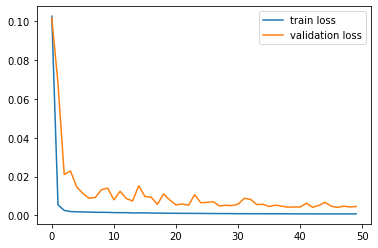

In [43]:
plt.plot(base_r.history['loss'], label = 'train loss')
plt.plot(base_r.history['val_loss'], label = 'validation loss')
plt.legend()

In [44]:
# 1. Make predictions on the test data
test_pred_base = base_model.predict(Xtest_scaled)

# 2. Inverse transform the predicted values back to the original scale
y_test_pred_base = scaler.inverse_transform(test_pred_base)

# 3. Calculate RMSE for test data
rmse_test_base = np.sqrt(mean_squared_error(y_test_original, y_test_pred_base))  # Compare actual vs predicted
print("Test RMSE:", rmse_test_base)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Test RMSE: 6.036250459729158


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train RMSE: 1.2191323337546514
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


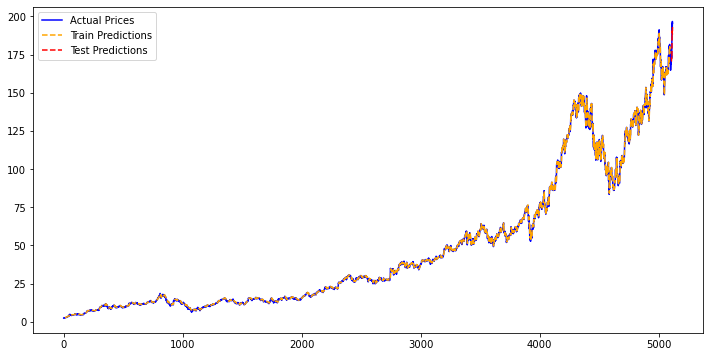

In [45]:
train_pred_base = base_model.predict(Xtrain_scaled)
y_train_pred_base = scaler.inverse_transform(train_pred_base)


rmse_train_base= np.sqrt(mean_squared_error(y_train_original, y_train_pred_base))  # Compare actual vs predicted
print("Train RMSE:", rmse_train_base)

T=10
train_idx[:T+1] = False # first T+1 values are not predictable

Ptrain_base = base_model.predict(Xtrain_scaled)
Ptest_base = base_model.predict(Xtest_scaled)

Ptrain_base = scaler.inverse_transform(Ptrain_base).flatten()
Ptest_base = scaler.inverse_transform(Ptest_base).flatten()

df['Base_LSTM Train Prediction'] = np.nan
df['Base_LSTM Test Prediction'] = np.nan
# Assign train predictions correctly to Base_LSTM Train Prediction
df.loc[df.index[T:len(Ptrain_base) + T], "Base_LSTM Train Prediction"] = Ptrain_base

# Fix test indexing and assign test predictions
test_idx_fixed = df.index[-len(Ptest_base):]  # Ensure test index matches Ptest length
df.loc[test_idx_fixed, "Base_LSTM Test Prediction"] = Ptest_base


plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Actual Prices', color='blue')
plt.plot(df['Base_LSTM Train Prediction'], label='Train Predictions', linestyle='dashed', color='orange')
plt.plot(df['Base_LSTM Test Prediction'], label='Test Predictions', linestyle='dashed', color='red')
plt.legend()
plt.show()

<AxesSubplot:>

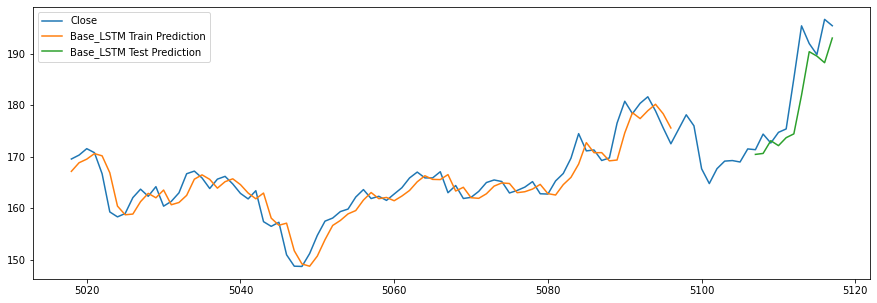

In [46]:
df.iloc[-100:][['Close', 'Base_LSTM Train Prediction', 'Base_LSTM Test Prediction']].plot(figsize=(15,5))

## **Model Selection Notes**
### **Why Choose `LSTM(16)` as the Base Model?**
- Since our dataset contains **5,118 data points**, a small LSTM model is appropriate to avoid overfitting.
- `LSTM(16)` provides **enough capacity to learn patterns** while maintaining simplicity.
- Larger LSTMs (`LSTM(50+`) might **overfit on a small dataset** and increase computation time.

### **Why Use `epochs=50`?**
- In our training results, the loss **stabilized around 10-15 epochs**.
- We use `epochs=50` to **ensure full convergence** while preventing excessive training.
- Early stopping could be applied if validation loss plateaus early.

### **Why Use `batch_size=16`?**
- **Balances training speed and model generalization**.
- Smaller batch sizes (`8` or `16`) tend to improve generalization by introducing noise into training.
- Batch sizes of `32+` might be too large for a dataset of this size and could lead to missing small-scale patterns.

### **Key Takeaways**
✅ `LSTM(16)` is a **lightweight yet effective** model for time series forecasting.  
✅ `epochs=50` is **sufficient for convergence** without unnecessary computation.  
✅ `batch_size=16` provides a **good trade-off between speed and accuracy**.  

Further tuning can involve testing **`LSTM(32)`, dropout adjustments, and early stopping**.



In [47]:
# Build the Stacked LSTM model
s_model_1 = Sequential()
s_model_1.add(LSTM(32, return_sequences=True, input_shape=(Xtrain_scaled.shape[1], 1)))  # Input shape should match X
#s_model_1.add(Dropout(0.3))
s_model_1.add(LSTM(16, return_sequences=False))  # No need for return_sequences=True in the last LSTM layer
#s_model_1.add(Dropout(0.3))
s_model_1.add(Dense(25))
s_model_1.add(Dense(1))  # Final layer for a single output value

s_model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │           425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,939 (31.01 KB)

 Trainable params: 7,939 (31.01 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Compile the model
s_model_1.compile(
    loss='mean_squared_error', 
    optimizer=Adam(learning_rate=0.0005)
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience= 10, restore_best_weights=True)

# Train the model with validation set that respects time order
s_model_1_r = s_model_1.fit(
    X_train, y_train, 
    batch_size = 32, 
    epochs = 100, 
    validation_data=(X_val, y_val),  
    callbacks=[early_stopping],
    verbose = 1 
)

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.5322 - val_loss: 0.2516
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - val_loss: 0.0565
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0243
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0192
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0226
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0084
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0193
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 10/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0078
Epoch 11/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 12/100
159/159 ━━━━━━━━━━━━━━━━━━━

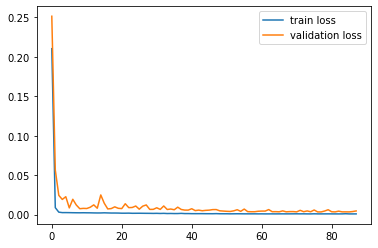

In [49]:
plt.plot(s_model_1_r.history['loss'], label = 'train loss')
plt.plot(s_model_1_r.history['val_loss'], label = 'validation loss')
plt.legend()

In [50]:
# Evaluate Test Data
y_test_pred_s_model_1, rmse_test_s_model_1 = evaluate_lstm_model(
    s_model_1, Xtest_scaled, y_test_original, scaler, dataset_type="Test"
)

# Evaluate Train Data
y_train_pred_s_model_1, rmse_train_s_model_1 = evaluate_lstm_model(
    s_model_1, Xtrain_scaled, y_train_original, scaler, dataset_type="Train"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
<Sequential name=sequential_1, built=True> RMSE: 5.144529410626337
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
<Sequential name=sequential_1, built=True> RMSE: 1.2468842552634944


In [51]:
# Build the Stacked LSTM model
s_model_2 = Sequential()
s_model_2.add(LSTM(64, return_sequences=True, input_shape=(Xtrain_scaled.shape[1], 1)))  # Input shape should match X
#s_model_1.add(Dropout(0.3))
s_model_2.add(LSTM(32, return_sequences=False))  # No need for return_sequences=True in the last LSTM layer
#s_model_1.add(Dropout(0.3))
s_model_2.add(Dense(25))
s_model_2.add(Dense(1))  # Final layer for a single output value

s_model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,163 (117.82 KB)

 Trainable params: 30,163 (117.82 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Compile the model
s_model_2.compile(
    loss='mean_squared_error', 
    optimizer=Adam(learning_rate=0.0005)
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience= 10, restore_best_weights=True)

# Train the model with validation set that respects time order
s_model_2_r = s_model_2.fit(
    X_train, y_train, 
    batch_size = 32, 
    epochs = 100, 
    validation_data=(X_val, y_val),  
    callbacks=[early_stopping],
    verbose = 1 
)

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2717 - val_loss: 0.0510
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - val_loss: 0.0205
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 0.0214
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0105
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0233
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0178
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0315
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0111
Epoch 10/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 0.0108
Epoch 11/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - val_loss: 0.0073
Epoch 12/100
159/159 ━━━━━━━━━━━━━━━━━━━

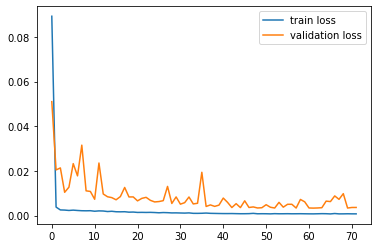

In [53]:
plt.plot(s_model_2_r.history['loss'], label = 'train loss')
plt.plot(s_model_2_r.history['val_loss'], label = 'validation loss')
plt.legend()

In [54]:
# Evaluate Test Data
y_test_pred_s_model_2, rmse_test_s_model_2 = evaluate_lstm_model(
    s_model_2, Xtest_scaled, y_test_original, scaler, dataset_type="Test"
)

# Evaluate Train Data
y_train_pred_s_model_2, rmse_train_s_model_2 = evaluate_lstm_model(
    s_model_2, Xtrain_scaled, y_train_original, scaler, dataset_type="Train"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
<Sequential name=sequential_2, built=True> RMSE: 5.097918536230085
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
<Sequential name=sequential_2, built=True> RMSE: 1.2696311825798636


In [55]:
# Build the Stacked LSTM model
stacked_model = Sequential()
stacked_model.add(LSTM(128, return_sequences=True, input_shape=(Xtrain_scaled.shape[1], 1)))  # Input shape should match X
#stacked_model.add(Dropout(0.2))
stacked_model.add(LSTM(64, return_sequences=False))  # No need for return_sequences=True in the last LSTM layer
#stacked_model.add(Dropout(0.2))
stacked_model.add(Dense(25))
stacked_model.add(Dense(1))  # Final layer for a single output value

stacked_model.summary() 


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 10, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Compile the model
stacked_model.compile(
    loss='mean_squared_error', 
    optimizer=Adam(learning_rate=0.0005)
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with validation set that respects time order
stacked_r = stacked_model.fit(
    X_train, y_train, 
    batch_size = 32, 
    epochs = 100, 
    validation_data=(X_val, y_val),  
    callbacks=[early_stopping],
    verbose = 1 
)

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1513 - val_loss: 0.0323
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0032 - val_loss: 0.0231
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0025 - val_loss: 0.0120
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0024 - val_loss: 0.0100
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0024 - val_loss: 0.0078
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0023 - val_loss: 0.0403
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0025 - val_loss: 0.0112
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0022 - val_loss: 0.0255
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0022 - val_loss: 0.0176
Epoch 10/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0021 - val_loss: 0.0203
Epoch 11/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0017 - val_loss: 0.0097
Epoch 12/100
159/159 ━━━━━━━━━

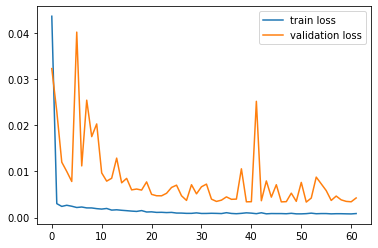

In [57]:
plt.plot(stacked_r.history['loss'], label = 'train loss')
plt.plot(stacked_r.history['val_loss'], label = 'validation loss')
plt.legend()

In [58]:
# Evaluate Test Data
y_test_pred_stacked, rmse_test_stacked = evaluate_lstm_model(
    stacked_model, Xtest_scaled, y_test_original, scaler, dataset_type="Test"
)

# Evaluate Train Data
y_train_pred_stacked, rmse_train_stacked = evaluate_lstm_model(
    stacked_model, Xtrain_scaled, y_train_original, scaler, dataset_type="Train"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
<Sequential name=sequential_3, built=True> RMSE: 4.872978040902615
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
<Sequential name=sequential_3, built=True> RMSE: 1.3440548561580183


In [59]:
# 1. Make predictions on the test data
test_pred = stacked_model.predict(Xtest_scaled)

# 2. Inverse transform the predicted values back to the original scale
y_test_pred = scaler.inverse_transform(test_pred)

# 3. Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test_original, y_test_pred))  # Compare actual vs predicted
print("Test RMSE:", rmse_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Test RMSE: 4.872978040902615


In [60]:
train_pred = stacked_model.predict(Xtrain_scaled)
y_train_pred = scaler.inverse_transform(train_pred)


rmse_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred))  # Compare actual vs predicted
print("Train RMSE:", rmse_train)


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Train RMSE: 1.3440548561580183


In [61]:
T=10
train_idx[:T+1] = False # first T+1 values are not predictable

Ptrain = stacked_model.predict(Xtrain_scaled)
Ptest = stacked_model.predict(Xtest_scaled)

Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

df.loc[df.index[T:len(Ptrain) + T], "LSTM Train Prediction"] = Ptrain

# Fix test indexing and assign test predictions
test_idx_fixed = df.index[-len(Ptest):]  # Ensure test index matches Ptest length
df.loc[test_idx_fixed, "LSTM Test Prediction"] = Ptest


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [62]:
print(len(df[train_idx]))  # Number of training data points in df
print(len(Ptrain))         # Number of predicted values


5086
5087


In [63]:
# First T+1 values are not predictable
df['LSTM Train Prediction'] = np.nan
df['LSTM Test Prediction'] = np.nan

# Ensure train_idx excludes first T values
train_idx[:T] = False  

# Generate Predictions
Ptrain = stacked_model.predict(Xtrain_scaled)
Ptest = stacked_model.predict(Xtest_scaled)

# Inverse transform to original scale
Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

# Store Predictions - Ensure proper alignment
df.loc[df.index[T:len(Ptrain) + T], "LSTM Train Prediction"] = Ptrain

# Fix test indexing and assign test predictions
test_idx_fixed = df.index[-len(Ptest):]  # Ensure test index matches Ptest length
df.loc[test_idx_fixed, "LSTM Test Prediction"] = Ptest


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


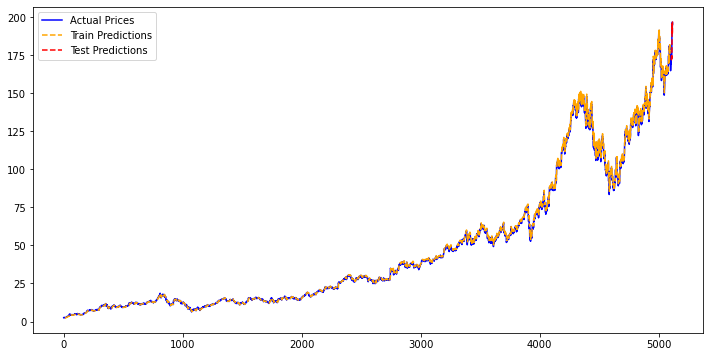

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Actual Prices', color='blue')
plt.plot(df['LSTM Train Prediction'], label='Train Predictions', linestyle='dashed', color='orange')
plt.plot(df['LSTM Test Prediction'], label='Test Predictions', linestyle='dashed', color='red')
plt.legend()
plt.show()

<AxesSubplot:>

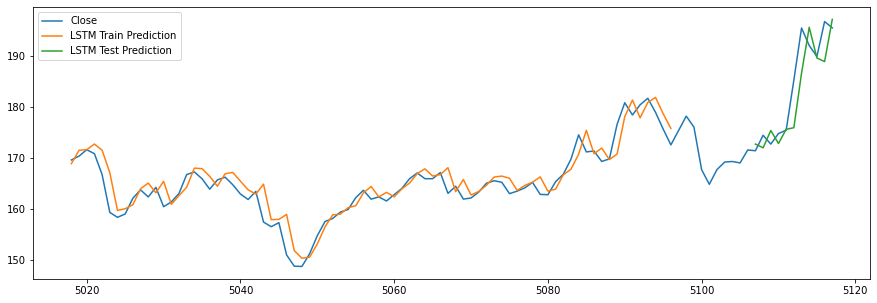

In [65]:
df.iloc[-100:][['Close', 'LSTM Train Prediction', 'LSTM Test Prediction']].plot(figsize=(15,5))

In [66]:
# Build the Stacked LSTM model
model_2 = Sequential()
model_2.add(LSTM(64, return_sequences=True, input_shape=(Xtrain_scaled.shape[1], 1)))  # Input shape should match X
model_2.add(Dropout(0.2))
model_2.add(LSTM(32, return_sequences=False))  # No need for return_sequences=True in the last LSTM layer
#model_2.add(Dropout(0.2))
model_2.add(Dense(25))
model_2.add(Dense(1))  # Final layer for a single output value

model_2.summary() 


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,163 (117.82 KB)

 Trainable params: 30,163 (117.82 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Compile the model
model_2.compile(
    loss='mean_squared_error', 
    optimizer=Adam(learning_rate=0.0005)
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with validation set that respects time order
model_r = model_2.fit(
    X_train, y_train, 
    batch_size = 32, 
    epochs = 100, 
    validation_data=(X_val, y_val),  
    callbacks=[early_stopping],
    verbose = 1 
)

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2988 - val_loss: 0.0635
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0359
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0199
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0210
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0138
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - val_loss: 0.0078
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0036 - val_loss: 0.0271
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0033 - val_loss: 0.0104
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0034 - val_loss: 0.0079
Epoch 10/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 0.0257
Epoch 11/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - val_loss: 0.0135
Epoch 12/100
159/159 ━━━━━━━━━━━━━━━━━

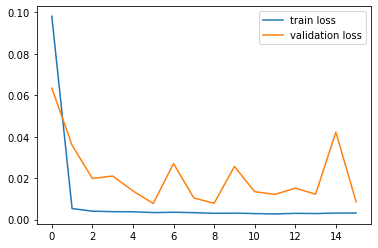

In [68]:
plt.plot(model_r.history['loss'], label = 'train loss')
plt.plot(model_r.history['val_loss'], label = 'validation loss')
plt.legend()

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define a function to evaluate RMSE, R², and MAE and store results
def evaluate_and_store_metrics(model_name, model, X_test_scaled, y_test_original, scaler, results_list):
    """
    Evaluates RMSE, R², and MAE for a given model on test data and appends results to a list.

    Parameters:
    - model_name: Name of the model (str)
    - model: Trained model
    - X_test_scaled: Scaled test features
    - y_test_original: Original (unscaled) test target values
    - scaler: Scaler object to inverse transform predictions
    - results_list: List to store results
    """
    # Make predictions
    y_test_pred_scaled = model.predict(X_test_scaled)
    
    # Inverse transform the predictions
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled)
    
    # Compute evaluation metrics
    rmse_test = np.sqrt(mean_squared_error(y_test_original, y_test_pred))
    mae_test = mean_absolute_error(y_test_original, y_test_pred)
    r2_test = r2_score(y_test_original, y_test_pred)

    # Store results
    results_list.append({
        "Model": model_name,
        "Test RMSE": rmse_test,
        "Test MAE": mae_test,
        "Test R²": r2_test
    })

# List to store model results
results = []

# Example: Evaluating multiple models
evaluate_and_store_metrics("Base Model_16", base_model, Xtest_scaled, y_test_original, scaler, results)
evaluate_and_store_metrics("LSTM Model_32", s_model_1, Xtest_scaled, y_test_original, scaler, results)
evaluate_and_store_metrics("LSTM Model_64", s_model_2, Xtest_scaled, y_test_original, scaler, results)
evaluate_and_store_metrics("LSTM Model_128", stacked_model, Xtest_scaled, y_test_original, scaler, results)
evaluate_and_store_metrics("LSTM Model_64_r", model_2, Xtest_scaled, y_test_original, scaler, results)

# Convert list to DataFrame
results_df = pd.DataFrame(results)

# Sort results by RMSE (lower is better)
results_df_sorted = results_df.sort_values(by='Test RMSE')

results_df_sorted


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Model  Test RMSE  Test MAE   Test R²
3   Stacked Model_128   4.872978  3.646326  0.754040
2    Stacked Model_64   5.097919  3.640159  0.730808
1    Stacked Model_32   5.144529  3.611801  0.725863
0       Base Model_16   6.036250  4.209579  0.622592
4  Stacked Model_64_r   9.633682  7.425558  0.038696

In [70]:
T=10
train_idx[:T+1] = False # first T+1 values are not predictable

Ptrain = stacked_model.predict(Xtrain_scaled)
Ptest = stacked_model.predict(Xtest_scaled)

Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

df.loc[df.index[T:len(Ptrain) + T], "LSTM Train Prediction"] = Ptrain

# Fix test indexing and assign test predictions
test_idx_fixed = df.index[-len(Ptest):]  # Ensure test index matches Ptest length
df.loc[test_idx_fixed, "LSTM Test Prediction"] = Ptest


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [71]:
# First T+1 values are not predictable
df['LSTM Train Prediction'] = np.nan
df['LSTM Test Prediction'] = np.nan

# Ensure train_idx excludes first T values
train_idx[:T] = False  

# Generate Predictions
Ptrain = stacked_model.predict(Xtrain_scaled)
Ptest = stacked_model.predict(Xtest_scaled)

# Inverse transform to original scale
Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

# Store Predictions - Ensure proper alignment
df.loc[df.index[T:len(Ptrain) + T], "LSTM Train Prediction"] = Ptrain

# Fix test indexing and assign test predictions
test_idx_fixed = df.index[-len(Ptest):]  # Ensure test index matches Ptest length
df.loc[test_idx_fixed, "LSTM Test Prediction"] = Ptest


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


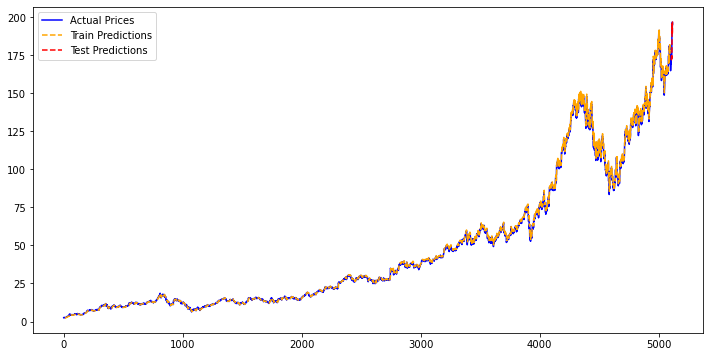

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Actual Prices', color='blue')
plt.plot(df['LSTM Train Prediction'], label='Train Predictions', linestyle='dashed', color='orange')
plt.plot(df['LSTM Test Prediction'], label='Test Predictions', linestyle='dashed', color='red')
plt.legend()
plt.show()

<AxesSubplot:>

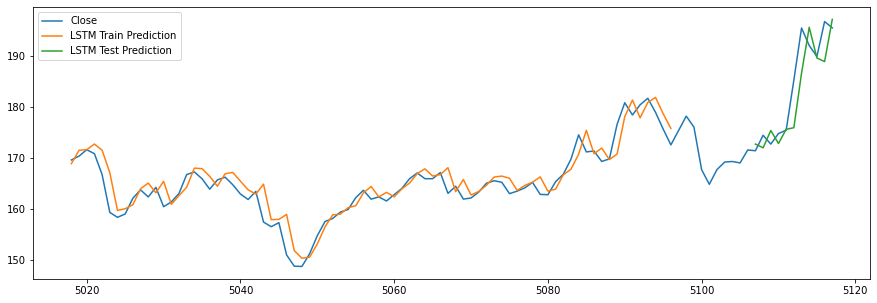

In [73]:
df.iloc[-100:][['Close', 'LSTM Train Prediction', 'LSTM Test Prediction']].plot(figsize=(15,5))